# Evaluating HRRR performance in wind gust potential

In [59]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
import pygrib

### Loading data

These datasets are not at the same time, so only general trends can be evaluated. 

Future - Find nearest METAR station to a HRRR prediction in order to evaluate specific predictions. 

In [60]:
Met_20170701 = Dataset(  # Metar
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/20170701_0000')
Met_20180613 = Dataset(  # Metar
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/20180613_0000')
#Hrrr = Dataset(  # HRRR
#    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/extract2Da.esrl_hrrr.201718201001300.nc')

Met_20190801 = Dataset( # Synced
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/2019_08_01/20190801_0300')
Hrrr = pygrib.open(  # Synced
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/2019_08_01/csu_econ.1921300000300.grib2')

Removing any wind gusts > 10,000 m/s, should only be NAN fill values (3.4028235e+38). 

In [61]:
met_lon = Met_20190801.variables['longitude']
met_lat = Met_20190801.variables['latitude']
met_gust = Met_20190801.variables['windGust']
met_temp = Met_20190801.variables['temperature']
met_windspeed = Met_20190801.variables['windSpeed']
met_press = Met_20190801.variables['seaLevelPress']

top = 49.3457868  # north lat
left = -124.7844079  # west lon
right = -66.9513812  # east lon
bottom = 24.7433195  # south lat

cell = []
for g, lon, lat, t, ws, p in zip(met_gust, met_lon, met_lat, 
                                     met_temp, met_windspeed, met_press):
    if left <= lon <= right and bottom <= lat <= top:
        cell.append((g, lon, lat, t, ws, p))

met_arr = np.asarray(cell)
np.nan_to_num(met_arr, False, 0)
met_arr.shape

/Applications/anaconda3/envs/wind_gust/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


(4394, 6)

In [62]:
#hrrr_gust = Hrrr.variables['GUST_P0_L1_GLC0']
#hrrr_lat = Hrrr.variables['gridlat_0']
#hrrr_lon = Hrrr.variables['gridlon_0']
hrrr_gust = Hrrr[9].values
hrrr_lat, hrrr_lon = Hrrr[9].latlons()


hrrr_gust_flat = np.concatenate(hrrr_gust)
hrrr_lat_flat = np.concatenate(hrrr_lat)
hrrr_lon_flat = np.concatenate(hrrr_lon)

cell = []
for g, lon, lat in zip(hrrr_gust_flat, hrrr_lon_flat, hrrr_lat_flat):
    cell.append((g, lon, lat))

hrrr_arr = np.asarray(cell)
np.nan_to_num(hrrr_arr, False, 0)
hrrr_arr

array([[   6.42367965, -122.719528  ,   21.138123  ],
       [   6.36117965, -122.69286132,   21.14511004],
       [   6.36117965, -122.6661903 ,   21.1520901 ],
       ...,
       [   4.42367965,  -60.99031194,   47.86277069],
       [   4.48617965,  -60.95374627,   47.85248789],
       [   4.54867965,  -60.91719277,   47.84219502]])

Looking for interesting features of the aggregate predictions. 

(0.0, 1000.0)

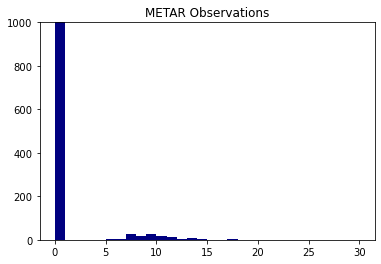

In [63]:
hist_metar = plt.hist(met_arr[:, 0], bins=30, color='navy', range=[0,30], )
plt.title("METAR Observations")
plt.ylim(0,1000)

(0.0, 1000000.0)

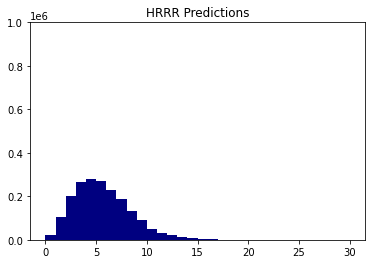

In [64]:
hist_hrrr = plt.hist(hrrr_arr[:, 0], bins=30, color='navy', range=[0,30], )
plt.title("HRRR Predictions")
plt.ylim(0,1000000)

### Comparing METAR observed wind gust to wind speed

"Time" would be a better x-axis, but I don't currently have data over time. 

In [65]:
met_arr[:,0].shape

(4394,)

Text(0, 0.5, 'Wind Gust (meter/sec)')

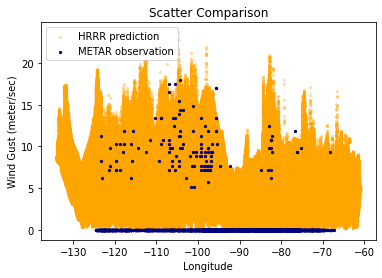

In [66]:
plt.scatter(hrrr_arr[:,1], hrrr_arr[:,0], color='orange', s=5, alpha=0.3, label='HRRR prediction')
plt.scatter(met_arr[:,1], met_arr[:,0],  color='navy', s=5, alpha=1, label='METAR observation')
plt.title("Scatter Comparison")
plt.legend(loc='upper left')
plt.xlabel("Longitude", size = 10)
plt.ylabel("Wind Gust (meter/sec)", size = 10)

Text(0, 0.5, 'meter/sec')

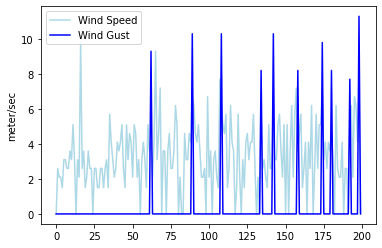

In [67]:
plt.plot(met_arr[0:200,4], color='LightBlue', label='Wind Speed')
plt.plot(met_arr[0:200,0], color='Blue', label='Wind Gust')
plt.legend()
plt.ylabel("meter/sec", size = 10)

### Testing the process of building the closest HRRR to METAR table. 
This scipy distance method is much faster.

In [68]:
def closest_node(metar, hrrrs):
    closest_index = distance.cdist([metar], hrrrs).argmin()
    return hrrrs[closest_index]

hrrr_data = hrrr_arr
lookup_dict = {}

for i in range(0,150): 
    metar_pt = (round(met_arr[i, 1],3), round(met_arr[i, 2],3))
    metar_gust = met_arr[i, 0]
    hrrr_pt = closest_node(metar_pt, hrrr_data[:, 1:3])
    hrrr_gust = hrrr_data[i, 0]
    lookup_dict[i] = {
        "metar": metar_pt,
        "hrrr": (round(hrrr_pt[0],3), round(hrrr_pt[1],3)),
        "hrrr gust": hrrr_gust,
        "metar gust": metar_gust
    }

### Make map figure with cartopy

Got error: "Shell is not a LinearRing" before, but it went away after changing projection to Mercator. 

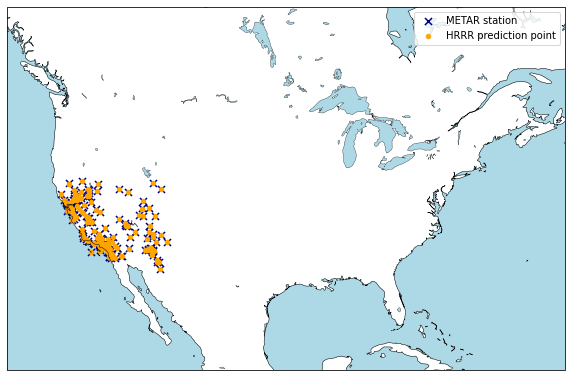

In [69]:
import cartopy.crs as ccrs
from cartopy import feature as cfeature

fig = plt.figure(figsize=(10, 10), facecolor='w')
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-130, -60, 20, 55], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, lw=0.5)
#ax.add_feature(cfeature.BORDERS, lw=0.5)
ax.add_feature(cfeature.OCEAN, zorder=0, color='lightblue', lw=0.3, edgecolor='none')
ax.add_feature(cfeature.LAKES, zorder=0, facecolor='lightblue', lw=0.3,  edgecolor='black')

metar_lons = []
metar_lats = []
hrrr_lons = []
hrrr_lats = []

for i in range(0,150):
    metar_lons.append(lookup_dict[i]['metar'][0])
    metar_lats.append(lookup_dict[i]['metar'][1])
    hrrr_lons.append(lookup_dict[i]['hrrr'][0])
    hrrr_lats.append(lookup_dict[i]['hrrr'][1])
    
plt.scatter(metar_lons, metar_lats, c='Navy', s=50, 
    marker='x', label="METAR station", transform=ccrs.PlateCarree())
plt.scatter(hrrr_lons, hrrr_lats, c='Orange', s=20, 
    label="HRRR prediction point", transform=ccrs.PlateCarree())

plt.legend()

plt.show()

### Testing accuracy of HRRR predictions

Text(0.5, 0, 'HRRR Gust')

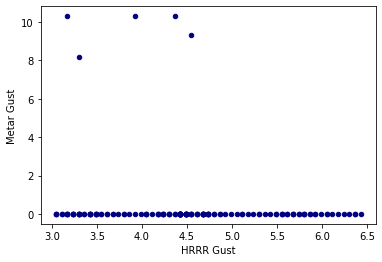

In [70]:
metar_gust = []
hrrr_gust = []

for i in range(0,150):
    metar_gust.append(lookup_dict[i]['metar gust'])
    hrrr_gust.append(lookup_dict[i]['hrrr gust'])
    
plt.scatter(hrrr_gust, metar_gust, c='Navy', s=20, label="METAR station")
    
plt.ylabel("Metar Gust", size = 10)
plt.xlabel("HRRR Gust", size = 10)